# AutoEncoder and GAN

In [1]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt

In [2]:
def plot_image(image):
    plt.imshow(image, cmap="binary")
    plt.axis("off")

In [3]:
def generate_3d_data(m, w1=0.1, w2=0.3, noise=0.1):
    angles = np.random.rand(m) * 3 * np.pi / 2 - 0.5
    data = np.empty((m, 3))
    data[:, 0] = np.cos(angles) + np.sin(angles)/2 + noise * np.random.randn(m) / 2
    data[:, 1] = np.sin(angles) * 0.7 + noise * np.random.randn(m) / 2
    data[:, 2] = data[:, 0] * w1 + data[:, 1] * w2 + noise * np.random.randn(m)
    return data

X_train = generate_3d_data(60)
X_train = X_train - X_train.mean(axis=0, keepdims=0)

### Simple linear AE

In [4]:
X_train.shape

(60, 3)

In [5]:
# AE much like PCA
encoder = keras.models.Sequential([keras.layers.Dense(2, input_shape=[3])])
decoder = keras.models.Sequential([keras.layers.Dense(3, input_shape=[2])])
autoencoder = keras.models.Sequential([encoder, decoder]) # connect two unconnected Sequential network!

autoencoder.compile(loss="mse", optimizer=keras.optimizers.SGD(learning_rate=0.1))

2022-08-09 01:02:47.602773: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-08-09 01:02:47.638009: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-08-09 01:02:47.638220: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-08-09 01:02:47.639037: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags

In [6]:
history = autoencoder.fit(X_train, X_train, epochs=20)

Epoch 1/20
2/2 [==============================] - 0s 3ms/step - loss: 0.2452
Epoch 2/20
2/2 [==============================] - 0s 2ms/step - loss: 0.1968
Epoch 3/20
2/2 [==============================] - 0s 1ms/step - loss: 0.1610
Epoch 4/20
2/2 [==============================] - 0s 2ms/step - loss: 0.1334
Epoch 5/20
2/2 [==============================] - 0s 2ms/step - loss: 0.1124
Epoch 6/20
2/2 [==============================] - 0s 2ms/step - loss: 0.0960
Epoch 7/20
2/2 [==============================] - 0s 1ms/step - loss: 0.0838
Epoch 8/20
2/2 [==============================] - 0s 1ms/step - loss: 0.0748
Epoch 9/20
2/2 [==============================] - 0s 2ms/step - loss: 0.0678
Epoch 10/20
2/2 [==============================] - 0s 1ms/step - loss: 0.0627
Epoch 11/20
2/2 [==============================] - 0s 2ms/step - loss: 0.0591
Epoch 12/20
2/2 [==============================] - 0s 2ms/step - loss: 0.0557
Epoch 13/20
2/2 [==============================] - 0s 2ms/step - loss: 0.

In [7]:
codings = encoder.predict(X_train)

그림 저장 linear_autoencoder_pca_plot


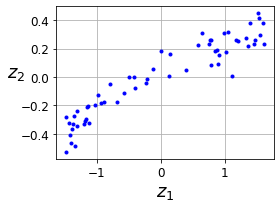

In [8]:
import os
# 깔끔한 그래프 출력을 위해
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# 그림을 저장할 위치
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "autoencoders"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID)
os.makedirs(IMAGES_PATH, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("그림 저장", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

fig = plt.figure(figsize=(4,3))
plt.plot(codings[:,0], codings[:, 1], "b.")
plt.xlabel("$z_1$", fontsize=18)
plt.ylabel("$z_2$", fontsize=18, rotation=0)
plt.grid(True)
save_fig("linear_autoencoder_pca_plot")
plt.show()

### Stacked AE

In [9]:
(X_train_full, y_train_full), (X_test, y_test) = keras.datasets.fashion_mnist.load_data()
X_train_full = X_train_full.astype(np.float32) / 255
X_test = X_test.astype(np.float32) / 255
X_train, X_valid = X_train_full[:-5000], X_train_full[-5000:]
y_train, y_valid = y_train_full[:-5000], y_train_full[-5000:]
def rounded_accuracy(y_true, y_pred): # keras metrics inputs label and value!
    return keras.metrics.binary_accuracy(tf.round(y_true), tf.round(y_pred)) # use binary accuracy to compute accuracy between images

In [10]:
stacked_encoder = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28,28]),
    keras.layers.Dense(100, activation="selu"),
    keras.layers.Dense(30, activation="selu")
])
stacked_decoder = keras.models.Sequential([
    keras.layers.Dense(100, activation="selu", input_shape=[30]),
    keras.layers.Dense(28*28, activation="sigmoid"), # use sigmoid as activation for output!
    keras.layers.Reshape([28,28])# keras.layers.Reshape!!
])

stacked_ae = keras.models.Sequential([stacked_encoder, stacked_decoder])
stacked_ae.compile(loss="binary_crossentropy", optimizer = keras.optimizers.Adam(), metrics=[rounded_accuracy]) # use BCE as loss fn!

In [11]:
history = stacked_ae.fit(X_train, X_train, epochs=50, validation_data=(X_valid, X_valid))

2022-08-09 01:04:25.088772: W tensorflow/core/common_runtime/bfc_allocator.cc:462] Allocator (GPU_0_bfc) ran out of memory trying to allocate 164.49MiB (rounded to 172480000)requested by op _EagerConst
If the cause is memory fragmentation maybe the environment variable 'TF_GPU_ALLOCATOR=cuda_malloc_async' will improve the situation. 
Current allocation summary follows.
Current allocation summary follows.
2022-08-09 01:04:25.088841: I tensorflow/core/common_runtime/bfc_allocator.cc:1010] BFCAllocator dump for GPU_0_bfc
2022-08-09 01:04:25.088875: I tensorflow/core/common_runtime/bfc_allocator.cc:1017] Bin (256): 	Total Chunks: 30, Chunks in use: 30. 7.5KiB allocated for chunks. 7.5KiB in use in bin. 328B client-requested in use in bin.
2022-08-09 01:04:25.088900: I tensorflow/core/common_runtime/bfc_allocator.cc:1017] Bin (512): 	Total Chunks: 4, Chunks in use: 4. 2.5KiB allocated for chunks. 2.5KiB in use in bin. 2.2KiB client-requested in use in bin.
2022-08-09 01:04:25.088923: I tens

InternalError: Failed copying input tensor from /job:localhost/replica:0/task:0/device:CPU:0 to /job:localhost/replica:0/task:0/device:GPU:0 in order to run _EagerConst: Dst tensor is not initialized.

In [24]:
def show_reconstructions(model, images=X_valid, n_images=5):
    reconstructions = model.predict(images[:n_images])
    fig = plt.figure(figsize=(n_images * 1.5, 3))
    for image_index in range(n_images):
        plt.subplot(2, n_images, 1 + image_index)
        plot_image(images[image_index]) # top is real
        plt.subplot(2, n_images, 1 + n_images + image_index)
        plot_image(reconstructions[image_index]) # botton is recon

그림 저장 reconstruction_plot


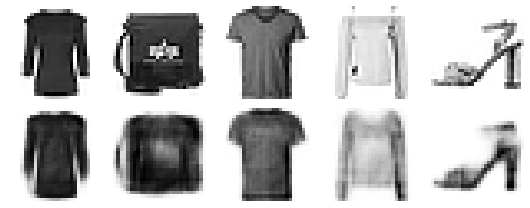

In [25]:
show_reconstructions(stacked_ae)
save_fig("reconstruction_plot")

In [28]:
from sklearn.manifold import TSNE

X_valid_compressed = stacked_encoder.predict(X_valid)
tsne = TSNE()
X_valid_2D = tsne.fit_transform(X_valid_compressed)

/home/dongho/anaconda3/envs/HOML/lib/python3.10/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/home/dongho/anaconda3/envs/HOML/lib/python3.10/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


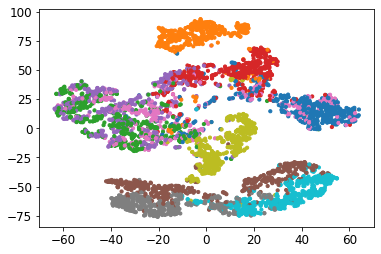

In [29]:
plt.scatter(X_valid_2D[:,0], X_valid_2D[:,1], c=y_valid, s=10, cmap="tab10") # pass list of labels to c for color! # s for number of colors

In [233]:
def plot_representation_in_2D(encoder, img_save_name,image=X_valid, distance = 100):
    X_valid_compressed = encoder.predict(image)
    tsne = TSNE()
    X_valid_2D = tsne.fit_transform(X_valid_compressed)
    #X_valid_2D = X_valid_compressed[:, :2]
    plt.figure(figsize=(10, 8))
    cmap = plt.cm.tab10
    plt.scatter(X_valid_2D[:, 0], X_valid_2D[:, 1], c=y_valid, s=10, cmap=cmap)
    image_positions = np.array([[1., 1.]])
    for index, position in enumerate(X_valid_2D):
        dist = np.sum((position - image_positions) ** 2, axis=1)
        if np.min(dist) > distance: # if far enough from other images
            image_positions = np.r_[image_positions, [position]]
            imagebox = mpl.offsetbox.AnnotationBbox(
                mpl.offsetbox.OffsetImage(image[index], cmap="binary"),
                position, bboxprops={"edgecolor": cmap(y_valid[index]), "lw": 2})
            plt.gca().add_artist(imagebox)
    plt.axis("off")
    save_fig(img_save_name)
    plt.show()

/home/dongho/anaconda3/envs/HOML/lib/python3.10/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/home/dongho/anaconda3/envs/HOML/lib/python3.10/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


그림 저장 stacked_ae_2D.png


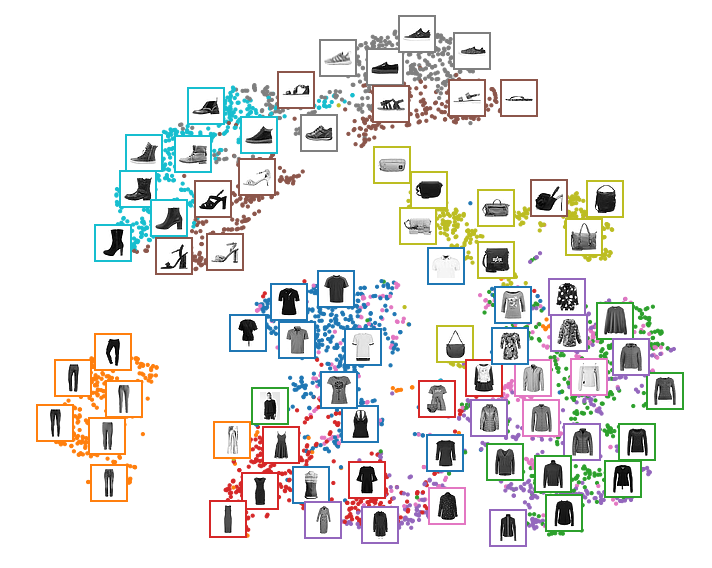

In [62]:
plot_representation_in_2D(stacked_encoder, "stacked_ae_2D.png", X_valid)

#### Tied Weights

In [56]:
class DenseTranspose(keras.layers.Layer):
    def __init__(self, dense, activation=None, **kwargs):
        self.dense = dense
        self.activation = keras.activations.get(activation)
        super().__init__(**kwargs)
        
    def build(self, batch_input_shape): # use self.add_weight to add weight to model!!
        self.biases = self.add_weight(name="bias", initializer="zeros", shape=[self.dense.input_shape[-1]]) # does not copy bias!!
        super().build(batch_input_shape)
    
    def call(self, inputs):
        z = tf.matmul(inputs, self.dense.weights[0], transpose_b=True)
        return self.activation(z + self.biases)

In [57]:
dense_1 = keras.layers.Dense(100, activation="selu")
dense_2 = keras.layers.Dense(30, activation="selu") # make layers to share it 

tied_encoder = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]), # use flatten to specify size for build() method!
    dense_1,
    dense_2
]) # after this, build method is called, making weights in Dense layers

tied_decoder = keras.models.Sequential([
    DenseTranspose(dense_2, activation="selu"),
    DenseTranspose(dense_1, activation="sigmoid"),
    keras.layers.Reshape([28, 28])
])

tied_ae = keras.models.Sequential([tied_encoder, tied_decoder])

In [58]:
tied_ae.compile(loss="binary_crossentropy", optimizer="adam", metrics=[rounded_accuracy])

In [50]:
tied_ae.fit(X_train, X_train, epochs=50, validation_data=(X_valid, X_valid))

Epoch 1/50
1719/1719 [==============================] - 3s 1ms/step - loss: 0.3097 - rounded_accuracy: 0.9117 - val_loss: 0.2902 - val_rounded_accuracy: 0.9310
Epoch 2/50
1719/1719 [==============================] - 2s 1ms/step - loss: 0.2851 - rounded_accuracy: 0.9336 - val_loss: 0.2846 - val_rounded_accuracy: 0.9361
Epoch 3/50
1719/1719 [==============================] - 2s 1ms/step - loss: 0.2816 - rounded_accuracy: 0.9367 - val_loss: 0.2823 - val_rounded_accuracy: 0.9379
Epoch 4/50
1719/1719 [==============================] - 4s 2ms/step - loss: 0.2798 - rounded_accuracy: 0.9383 - val_loss: 0.2810 - val_rounded_accuracy: 0.9383
Epoch 5/50
1719/1719 [==============================] - 2s 1ms/step - loss: 0.2787 - rounded_accuracy: 0.9393 - val_loss: 0.2800 - val_rounded_accuracy: 0.9398
Epoch 6/50
1719/1719 [==============================] - 2s 1ms/step - loss: 0.2777 - rounded_accuracy: 0.9400 - val_loss: 0.2789 - val_rounded_accuracy: 0.9402
Epoch 7/50
1719/1719 [==================

/home/dongho/anaconda3/envs/HOML/lib/python3.10/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/home/dongho/anaconda3/envs/HOML/lib/python3.10/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


그림 저장 tied_ae_2D


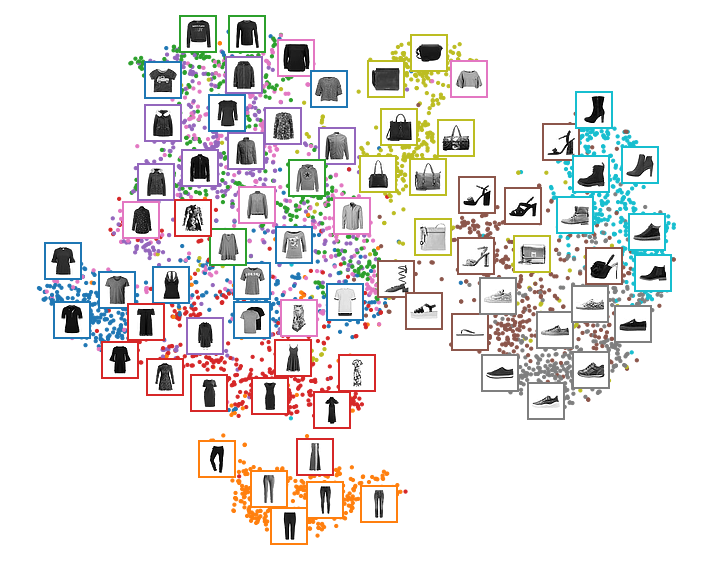

In [64]:
plot_representation_in_2D(tied_encoder, "tied_ae_2D", X_valid)

### Train One AE at a time

In [65]:
def train_autoencoder(n_neurons, X_train, X_valid, loss, optimizer,
                      n_epochs=10, output_activation=None, metrics=None):
    n_inputs = X_train.shape[-1]
    encoder = keras.models.Sequential([
        keras.layers.Dense(n_neurons, activation="selu", input_shape=[n_inputs])
    ])
    decoder = keras.models.Sequential([
        keras.layers.Dense(n_inputs, activation=output_activation),
    ])
    autoencoder = keras.models.Sequential([encoder, decoder])
    autoencoder.compile(optimizer, loss, metrics=metrics)
    autoencoder.fit(X_train, X_train, epochs=n_epochs,
                    validation_data=(X_valid, X_valid))
    return encoder, decoder, encoder(X_train), encoder(X_valid)

In [66]:
K = keras.backend
X_train_flat = K.batch_flatten(X_train) # flatten data
X_valid_flat = K.batch_flatten(X_valid)

enc1, dec1, X_train_enc1, X_valid_enc1 = train_autoencoder(
    100, X_train_flat, X_valid_flat, "binary_crossentropy",
    keras.optimizers.Adam(),n_epochs=50, output_activation="sigmoid",
    metrics=[rounded_accuracy])

enc2, dec2, _, _ = train_autoencoder(
    30, X_train_enc1, X_valid_enc1, "mse", keras.optimizers.Adam(),
    n_epochs=50, output_activation="selu")


Epoch 1/50
1719/1719 [==============================] - 2s 1ms/step - loss: 0.3014 - rounded_accuracy: 0.9226 - val_loss: 0.2814 - val_rounded_accuracy: 0.9409
Epoch 2/50
1719/1719 [==============================] - 2s 1ms/step - loss: 0.2762 - rounded_accuracy: 0.9455 - val_loss: 0.2756 - val_rounded_accuracy: 0.9473
Epoch 3/50
1719/1719 [==============================] - 2s 1ms/step - loss: 0.2730 - rounded_accuracy: 0.9487 - val_loss: 0.2741 - val_rounded_accuracy: 0.9490
Epoch 4/50
1719/1719 [==============================] - 2s 1ms/step - loss: 0.2719 - rounded_accuracy: 0.9498 - val_loss: 0.2735 - val_rounded_accuracy: 0.9503
Epoch 5/50
1719/1719 [==============================] - 2s 1ms/step - loss: 0.2713 - rounded_accuracy: 0.9503 - val_loss: 0.2728 - val_rounded_accuracy: 0.9502
Epoch 6/50
1719/1719 [==============================] - 2s 1ms/step - loss: 0.2709 - rounded_accuracy: 0.9506 - val_loss: 0.2725 - val_rounded_accuracy: 0.9507
Epoch 7/50
1719/1719 [==================

In [68]:
stacked_ae_1_by_1 = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    enc1,
    enc2,
    dec2,
    dec1,
    keras.layers.Reshape([28,28])
])

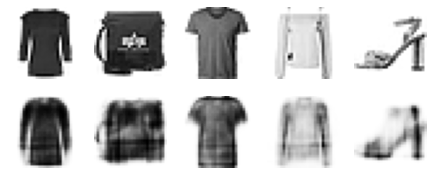

In [73]:
show_reconstructions(stacked_ae_1_by_1)
plt.show()

In [74]:
stacked_ae_encoder = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    enc1,
    enc2
])

/home/dongho/anaconda3/envs/HOML/lib/python3.10/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/home/dongho/anaconda3/envs/HOML/lib/python3.10/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


그림 저장 stacked_ae_1_1_without_finetuning


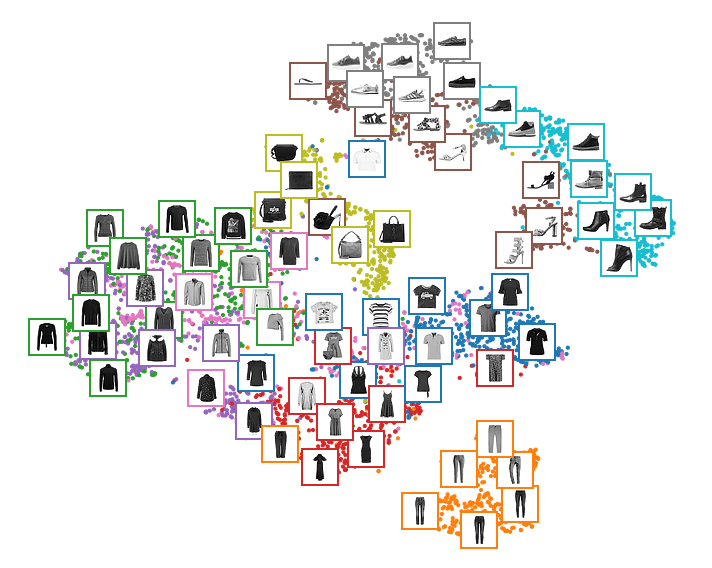

In [77]:
plot_representation_in_2D(stacked_ae_encoder ,"stacked_ae_1_1_without_finetuning", X_valid)

In [78]:
stacked_ae_1_by_1.compile(loss="binary_crossentropy",
                          optimizer = keras.optimizers.Adam(), metrics=[rounded_accuracy])
history = stacked_ae_1_by_1.fit(X_train, X_train, epochs=10, validation_data=(
    X_valid, X_valid))

Epoch 1/10
1719/1719 [==============================] - 3s 1ms/step - loss: 0.2821 - rounded_accuracy: 0.9366 - val_loss: 0.2826 - val_rounded_accuracy: 0.9370
Epoch 2/10
1719/1719 [==============================] - 3s 1ms/step - loss: 0.2798 - rounded_accuracy: 0.9389 - val_loss: 0.2813 - val_rounded_accuracy: 0.9381
Epoch 3/10
1719/1719 [==============================] - 3s 1ms/step - loss: 0.2788 - rounded_accuracy: 0.9397 - val_loss: 0.2805 - val_rounded_accuracy: 0.9388
Epoch 4/10
1719/1719 [==============================] - 2s 1ms/step - loss: 0.2779 - rounded_accuracy: 0.9405 - val_loss: 0.2792 - val_rounded_accuracy: 0.9406
Epoch 5/10
1719/1719 [==============================] - 2s 1ms/step - loss: 0.2772 - rounded_accuracy: 0.9411 - val_loss: 0.2787 - val_rounded_accuracy: 0.9408
Epoch 6/10
1719/1719 [==============================] - 6s 4ms/step - loss: 0.2766 - rounded_accuracy: 0.9416 - val_loss: 0.2783 - val_rounded_accuracy: 0.9413
Epoch 7/10
1719/1719 [==================

/home/dongho/anaconda3/envs/HOML/lib/python3.10/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/home/dongho/anaconda3/envs/HOML/lib/python3.10/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


그림 저장 stacked_ae_1_1_with_finetuning


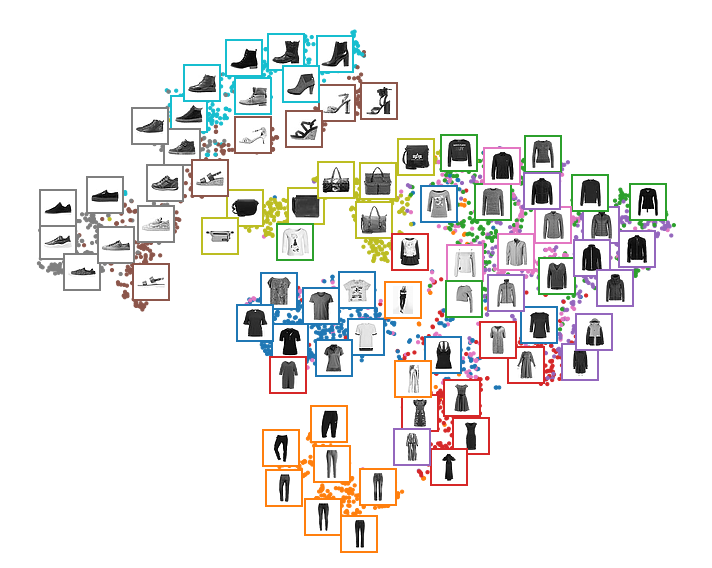

In [79]:
plot_representation_in_2D(stacked_ae_encoder ,"stacked_ae_1_1_with_finetuning", X_valid)

### Convolutional AE

In [95]:
conv_encoder = keras.models.Sequential([
    keras.layers.Reshape([28, 28, 1], input_shape=[28,28]),
    keras.layers.Conv2D(16, kernel_size=3, padding="same", activation="selu"),
    keras.layers.MaxPool2D(pool_size=2),
    keras.layers.Conv2D(32, kernel_size=3, padding="same", activation="selu"),
    keras.layers.MaxPool2D(pool_size=2),
    keras.layers.Conv2D(64, kernel_size=3, padding="same", activation="selu"),
    keras.layers.MaxPool2D(pool_size=2),
])

conv_decoder = keras.models.Sequential([
    keras.layers.Conv2DTranspose(32, kernel_size=3, strides=2, padding="valid",
                                 activation="selu", input_shape=[3, 3, 64]), # use conv2dtranspose to make input imgs larger but shorter
    keras.layers.Conv2DTranspose(16, kernel_size=3, strides=2, padding="same",
                                 activation="selu"),
    keras.layers.Conv2DTranspose(1, kernel_size=3, strides=2, padding="same",
                                 activation="sigmoid"),
    keras.layers.Reshape([28, 28])
])

conv_ae = keras.models.Sequential([conv_encoder, conv_decoder])

In [96]:
conv_ae.compile(loss="binary_crossentropy", optimizer="adam", metrics=[rounded_accuracy])
history = conv_ae.fit(X_train, X_train, epochs=50, validation_data=(X_valid, X_valid))

Epoch 1/50
1719/1719 [==============================] - 19s 11ms/step - loss: 0.2914 - rounded_accuracy: 0.9292 - val_loss: 0.2734 - val_rounded_accuracy: 0.9442
Epoch 2/50
1719/1719 [==============================] - 21s 12ms/step - loss: 0.2683 - rounded_accuracy: 0.9487 - val_loss: 0.2670 - val_rounded_accuracy: 0.9519
Epoch 3/50
1719/1719 [==============================] - 20s 12ms/step - loss: 0.2642 - rounded_accuracy: 0.9533 - val_loss: 0.2643 - val_rounded_accuracy: 0.9547
Epoch 4/50
1719/1719 [==============================] - 21s 12ms/step - loss: 0.2619 - rounded_accuracy: 0.9560 - val_loss: 0.2623 - val_rounded_accuracy: 0.9568
Epoch 5/50
1719/1719 [==============================] - 20s 12ms/step - loss: 0.2604 - rounded_accuracy: 0.9579 - val_loss: 0.2614 - val_rounded_accuracy: 0.9579
Epoch 6/50
1719/1719 [==============================] - 19s 11ms/step - loss: 0.2594 - rounded_accuracy: 0.9592 - val_loss: 0.2609 - val_rounded_accuracy: 0.9583
Epoch 7/50
1719/1719 [======

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



In [97]:
conv_encoder_flatten = keras.models.Sequential([
    conv_encoder,
    keras.layers.Flatten(),
])

/home/dongho/anaconda3/envs/HOML/lib/python3.10/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/home/dongho/anaconda3/envs/HOML/lib/python3.10/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


그림 저장 conv_encoder_2D


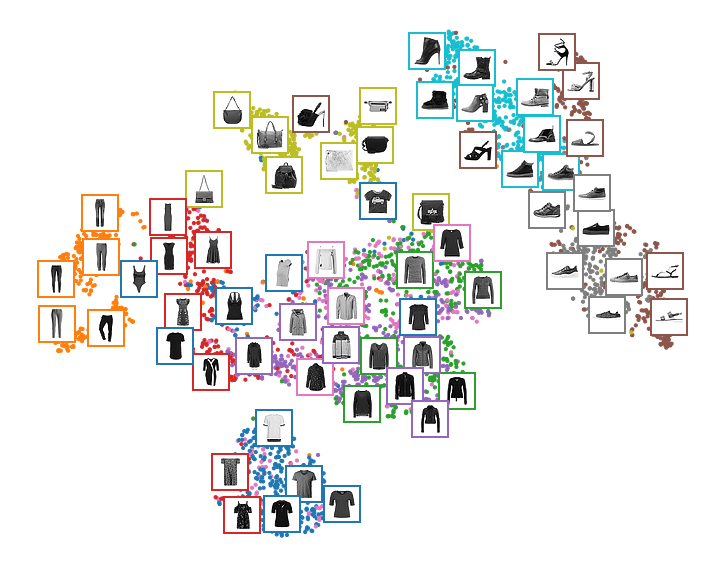

In [98]:
plot_representation_in_2D(conv_encoder_flatten ,"conv_encoder_2D", X_valid)

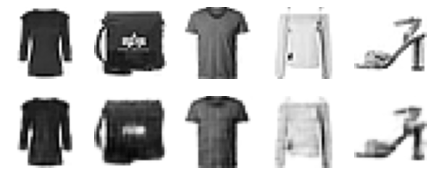

In [99]:
show_reconstructions(conv_ae)
plt.show()

### Recurrent AE

In [100]:
recurrent_encoder = keras.models.Sequential([
    keras.layers.LSTM(100, return_sequences=True, input_shape=[None, 28]), # feed input_shape like this!!
    keras.layers.LSTM(30),# return one vector!
])

recurrent_decoder = keras.models.Sequential([
    keras.layers.RepeatVector(28, input_shape=[30]), # repeat the vector 28 times!
    keras.layers.LSTM(100, return_sequences=True),
    keras.layers.TimeDistributed(keras.layers.Dense(28, activation="sigmoid"))
])

recurrent_ae = keras.models.Sequential([recurrent_encoder, recurrent_decoder])

In [101]:
recurrent_ae.compile(loss="binary_crossentropy", optimizer="adam", metrics=[rounded_accuracy])
history = recurrent_ae.fit(X_train, X_train, epochs=50, validation_data=(X_valid, X_valid))

Epoch 1/50
1719/1719 [==============================] - 36s 20ms/step - loss: 0.3426 - rounded_accuracy: 0.8837 - val_loss: 0.3141 - val_rounded_accuracy: 0.9072
Epoch 2/50
1719/1719 [==============================] - 30s 17ms/step - loss: 0.3047 - rounded_accuracy: 0.9135 - val_loss: 0.3023 - val_rounded_accuracy: 0.9163
Epoch 3/50
1719/1719 [==============================] - 33s 19ms/step - loss: 0.2944 - rounded_accuracy: 0.9225 - val_loss: 0.2919 - val_rounded_accuracy: 0.9257
Epoch 4/50
1719/1719 [==============================] - 31s 18ms/step - loss: 0.2877 - rounded_accuracy: 0.9284 - val_loss: 0.2883 - val_rounded_accuracy: 0.9290
Epoch 5/50
1719/1719 [==============================] - 33s 19ms/step - loss: 0.2837 - rounded_accuracy: 0.9321 - val_loss: 0.2840 - val_rounded_accuracy: 0.9333
Epoch 6/50
1719/1719 [==============================] - 32s 19ms/step - loss: 0.2807 - rounded_accuracy: 0.9349 - val_loss: 0.2808 - val_rounded_accuracy: 0.9360
Epoch 7/50
  91/1719 [>.....

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



1719/1719 [==============================] - 32s 18ms/step - loss: 0.2644 - rounded_accuracy: 0.9517 - val_loss: 0.2661 - val_rounded_accuracy: 0.9513
Epoch 38/50
1719/1719 [==============================] - 30s 18ms/step - loss: 0.2643 - rounded_accuracy: 0.9518 - val_loss: 0.2658 - val_rounded_accuracy: 0.9519
Epoch 39/50
1719/1719 [==============================] - 32s 18ms/step - loss: 0.2641 - rounded_accuracy: 0.9520 - val_loss: 0.2657 - val_rounded_accuracy: 0.9520
Epoch 40/50
1719/1719 [==============================] - 33s 19ms/step - loss: 0.2641 - rounded_accuracy: 0.9521 - val_loss: 0.2660 - val_rounded_accuracy: 0.9517
Epoch 41/50
1719/1719 [==============================] - 31s 18ms/step - loss: 0.2639 - rounded_accuracy: 0.9522 - val_loss: 0.2656 - val_rounded_accuracy: 0.9520
Epoch 42/50
1719/1719 [==============================] - 29s 17ms/step - loss: 0.2639 - rounded_accuracy: 0.9523 - val_loss: 0.2654 - val_rounded_accuracy: 0.9522
Epoch 43/50
1186/1719 [===========

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



/home/dongho/anaconda3/envs/HOML/lib/python3.10/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/home/dongho/anaconda3/envs/HOML/lib/python3.10/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


그림 저장 recurrent_encoder_2D


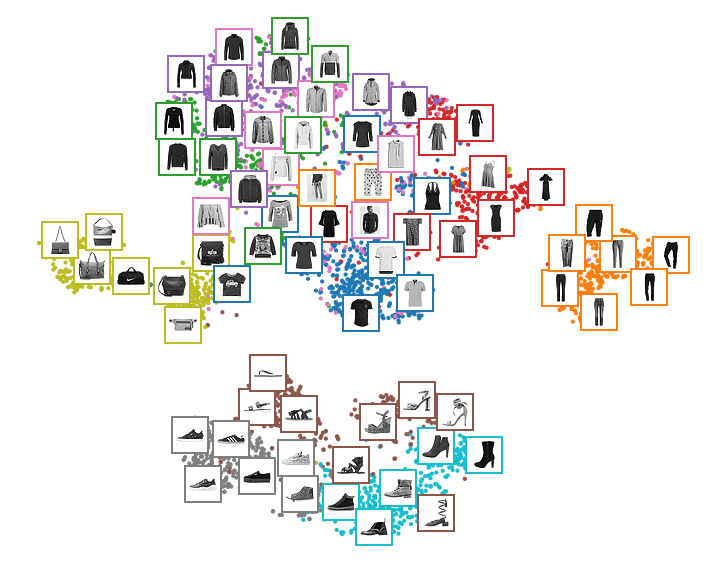

In [102]:
plot_representation_in_2D(recurrent_encoder ,"recurrent_encoder_2D", X_valid)

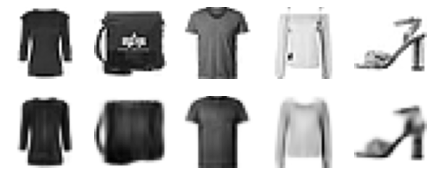

In [103]:
show_reconstructions(recurrent_ae)
plt.show()

## Denoising Autoencoder

In [106]:
denoising_encoder = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.Dropout(0.5),
    keras.layers.GaussianNoise(stddev=0.1),
    keras.layers.Dense(100, activation="selu"),
    keras.layers.Dense(30, activation="selu"),
])

denoising_decoder = keras.models.Sequential([
    keras.layers.Dense(100, activation="selu", input_shape=[30]),
    keras.layers.Dense(28*28, activation="sigmoid"),
    keras.layers.Reshape([28, 28])
])

denoising_ae = keras.models.Sequential([denoising_encoder, denoising_decoder])

In [107]:
denoising_ae.compile(loss="binary_crossentropy", optimizer="adam", metrics=[rounded_accuracy])
history = denoising_ae.fit(X_train, X_train, epochs=20, validation_data=(X_valid, X_valid))

Epoch 1/20
1719/1719 [==============================] - 7s 4ms/step - loss: 0.3194 - rounded_accuracy: 0.9019 - val_loss: 0.2978 - val_rounded_accuracy: 0.9229
Epoch 2/20
1719/1719 [==============================] - 2s 1ms/step - loss: 0.2992 - rounded_accuracy: 0.9185 - val_loss: 0.2920 - val_rounded_accuracy: 0.9277
Epoch 3/20
1719/1719 [==============================] - 2s 1ms/step - loss: 0.2956 - rounded_accuracy: 0.9215 - val_loss: 0.2901 - val_rounded_accuracy: 0.9293
Epoch 4/20
1719/1719 [==============================] - 2s 1ms/step - loss: 0.2936 - rounded_accuracy: 0.9229 - val_loss: 0.2880 - val_rounded_accuracy: 0.9308
Epoch 5/20
1719/1719 [==============================] - 2s 1ms/step - loss: 0.2924 - rounded_accuracy: 0.9239 - val_loss: 0.2869 - val_rounded_accuracy: 0.9317
Epoch 6/20
1719/1719 [==============================] - 6s 4ms/step - loss: 0.2915 - rounded_accuracy: 0.9245 - val_loss: 0.2861 - val_rounded_accuracy: 0.9319
Epoch 7/20
1719/1719 [==================

/home/dongho/anaconda3/envs/HOML/lib/python3.10/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/home/dongho/anaconda3/envs/HOML/lib/python3.10/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


그림 저장 denoising_ae_2D


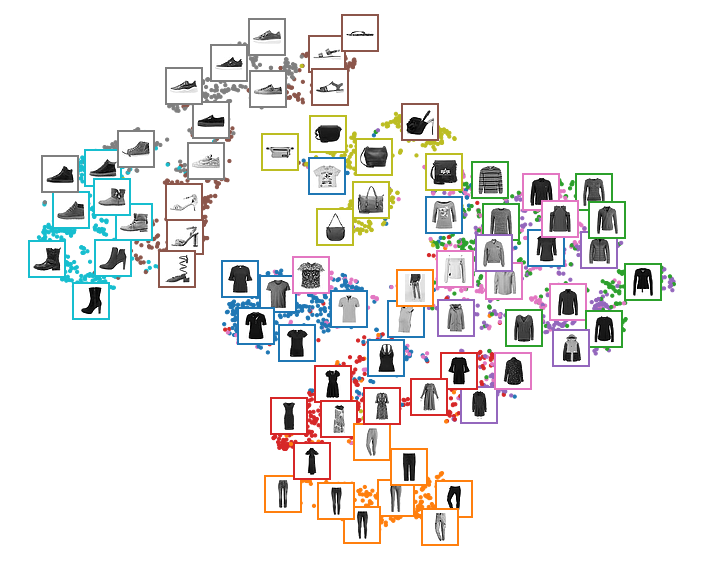

In [108]:
plot_representation_in_2D(denoising_encoder ,"denoising_ae_2D", X_valid)

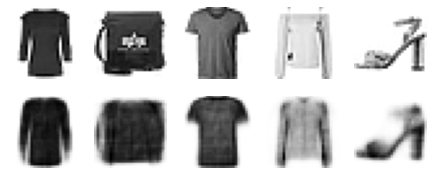

In [109]:
show_reconstructions(denoising_ae)
plt.show()

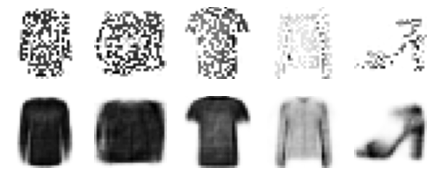

In [112]:
# using noised images to show it's power
dropout = keras.layers.Dropout(0.5)
show_reconstructions(denoising_ae, dropout(X_valid, training=True), 5)# we can apply noise to images like this!

### Sparse AE

In [115]:
sparse_l1_encoder = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.Dense(100, activation="selu"),
    keras.layers.Dense(300, activation="sigmoid"),# use sigmoid as activation fn!
    keras.layers.ActivityRegularization(l1=1e-3)
])

sparse_l1_decoder = keras.models.Sequential([
    keras.layers.Dense(100, activation="selu", input_shape=[300]),
    keras.layers.Dense(28*28, activation="sigmoid"),
    keras.layers.Reshape([28, 28])
])

sparse_l1_ae = keras.models.Sequential([sparse_l1_encoder, sparse_l1_decoder])

In [116]:
sparse_l1_ae.compile(loss="binary_crossentropy", optimizer="adam", metrics=[rounded_accuracy])
history = sparse_l1_ae.fit(X_train, X_train, epochs=20, validation_data=(X_valid, X_valid))

Epoch 1/20
1719/1719 [==============================] - 3s 2ms/step - loss: 0.3415 - rounded_accuracy: 0.8909 - val_loss: 0.3139 - val_rounded_accuracy: 0.9132
Epoch 2/20
1719/1719 [==============================] - 2s 1ms/step - loss: 0.3048 - rounded_accuracy: 0.9181 - val_loss: 0.3016 - val_rounded_accuracy: 0.9221
Epoch 3/20
1719/1719 [==============================] - 2s 1ms/step - loss: 0.2965 - rounded_accuracy: 0.9254 - val_loss: 0.2955 - val_rounded_accuracy: 0.9280
Epoch 4/20
1719/1719 [==============================] - 3s 1ms/step - loss: 0.2917 - rounded_accuracy: 0.9298 - val_loss: 0.2919 - val_rounded_accuracy: 0.9305
Epoch 5/20
1719/1719 [==============================] - 2s 1ms/step - loss: 0.2887 - rounded_accuracy: 0.9326 - val_loss: 0.2895 - val_rounded_accuracy: 0.9334
Epoch 6/20
1719/1719 [==============================] - 2s 1ms/step - loss: 0.2865 - rounded_accuracy: 0.9345 - val_loss: 0.2874 - val_rounded_accuracy: 0.9351
Epoch 7/20
1719/1719 [==================

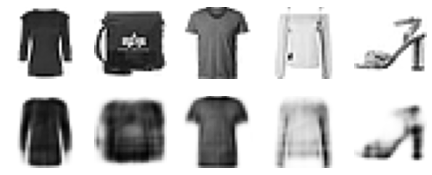

In [117]:
show_reconstructions(sparse_l1_ae)
plt.show()

In [119]:
K = keras.backend
kl_divergence = keras.losses.kullback_leibler_divergence

class KLDivergenceRegularizer(keras.regularizers.Regularizer):
    def __init__(self, weight, target=0.1):
        self.weight = weight
        self.target = target
        pass
    def __call__(self, inputs):
        mean_activities = K.mean(inputs, axis=0)
        return self.weight*(
            kl_divergence(self.target, mean_activities)+
            kl_divergence(1-self.target, 1-mean_activities)) #use 1-target becaus target's sum is not 1

In [126]:
kld_reg = KLDivergenceRegularizer(weight=0.5, target=0.1)
sparse_kl_encoder = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.Dense(100, activation="selu"),
    keras.layers.Dense(300, activation="sigmoid", activity_regularizer=kld_reg),# use sigmoid as activation fn!
])

sparse_kl_decoder = keras.models.Sequential([
    keras.layers.Dense(100, activation="selu", input_shape=[300]),
    keras.layers.Dense(28*28, activation="sigmoid"),
    keras.layers.Reshape([28, 28])
])

sparse_kl_ae = keras.models.Sequential([sparse_kl_encoder, sparse_kl_decoder])

In [127]:
sparse_kl_ae.compile(loss="binary_crossentropy", optimizer="adam", metrics=[rounded_accuracy])
history = sparse_kl_ae.fit(X_train, X_train, epochs=20, validation_data=(X_valid, X_valid))

Epoch 1/20
1719/1719 [==============================] - 3s 2ms/step - loss: 0.3565 - rounded_accuracy: 0.8802 - val_loss: 0.3143 - val_rounded_accuracy: 0.9127
Epoch 2/20
1719/1719 [==============================] - 3s 2ms/step - loss: 0.3049 - rounded_accuracy: 0.9179 - val_loss: 0.3009 - val_rounded_accuracy: 0.9218
Epoch 3/20
1719/1719 [==============================] - 3s 2ms/step - loss: 0.2942 - rounded_accuracy: 0.9276 - val_loss: 0.2912 - val_rounded_accuracy: 0.9317
Epoch 4/20
1719/1719 [==============================] - 3s 2ms/step - loss: 0.2877 - rounded_accuracy: 0.9335 - val_loss: 0.2879 - val_rounded_accuracy: 0.9348
Epoch 5/20
1719/1719 [==============================] - 3s 2ms/step - loss: 0.2839 - rounded_accuracy: 0.9368 - val_loss: 0.2841 - val_rounded_accuracy: 0.9375
Epoch 6/20
1719/1719 [==============================] - 3s 2ms/step - loss: 0.2811 - rounded_accuracy: 0.9393 - val_loss: 0.2815 - val_rounded_accuracy: 0.9399
Epoch 7/20
1719/1719 [==================

In [122]:
def plot_percent_hist(ax, data, bins):
    counts, _ = np.histogram(data, bins=bins)
    widths = bins[1:] - bins[:-1]
    x = bins[:-1] + widths / 2
    ax.bar(x, counts / len(data), width=widths*0.8)
    ax.xaxis.set_ticks(bins)
    ax.yaxis.set_major_formatter(mpl.ticker.FuncFormatter(
        lambda y, position: "{}%".format(int(np.round(100 * y)))))
    ax.grid(True)
def plot_activations_histogram(encoder, height=1, n_bins=10):
    X_valid_codings = encoder(X_valid).numpy()
    activation_means = X_valid_codings.mean(axis=0)
    mean = activation_means.mean()
    bins = np.linspace(0, 1, n_bins + 1)

    fig, [ax1, ax2] = plt.subplots(figsize=(10, 3), nrows=1, ncols=2, sharey=True)
    plot_percent_hist(ax1, X_valid_codings.ravel(), bins)
    ax1.plot([mean, mean], [0, height], "k--", label="Overall Mean = {:.2f}".format(mean))
    ax1.legend(loc="upper center", fontsize=14)
    ax1.set_xlabel("Activation")
    ax1.set_ylabel("% Activations")
    ax1.axis([0, 1, 0, height])
    plot_percent_hist(ax2, activation_means, bins)
    ax2.plot([mean, mean], [0, height], "k--")
    ax2.set_xlabel("Neuron Mean Activation")
    ax2.set_ylabel("% Neurons")
    ax2.axis([0, 1, 0, height])

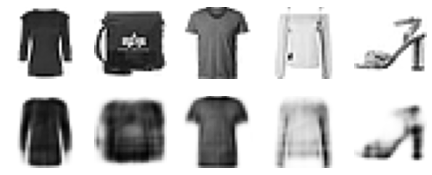

In [128]:
show_reconstructions(sparse_l1_ae)
plt.show()

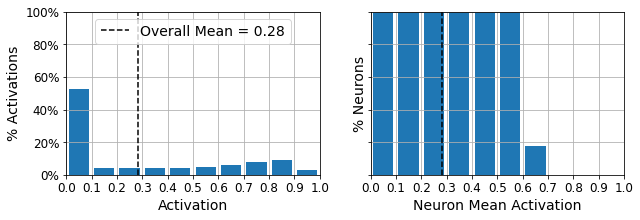

In [129]:
plot_activations_histogram(sparse_kl_ae)

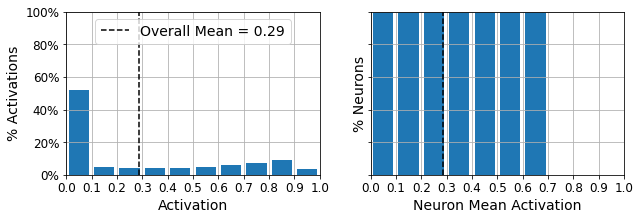

In [130]:
plot_activations_histogram(sparse_l1_ae)

## Variational AE

In [132]:
class Sampling(keras.layers.Layer):
    def call(self, inputs):
        mean, log_var = inputs # input mean and log_var !!
        return K.random_normal(tf.shape(log_var)) * K.exp(log_var/2) + mean

In [254]:
codings_size = 30
# functional API
inputs = keras.layers.Input(shape=[28,28])
z = keras.layers.Reshape([28, 28, 1])(inputs)
z = keras.layers.Conv2D(16, kernel_size=3, padding="same", activation="selu")(z)
z = keras.layers.MaxPool2D(pool_size=2)(z)
z = keras.layers.Conv2D(32, kernel_size=3, padding="same", activation="selu")(z)
z = keras.layers.MaxPool2D(pool_size=2)(z)
z = keras.layers.Conv2D(64, kernel_size=3, padding="same", activation="selu")(z)
z = keras.layers.MaxPool2D(pool_size=2)(z)
z = keras.layers.Flatten()(z)
z = keras.layers.Dense(300, activation="selu")(z)
z = keras.layers.Dense(100, activation="selu")(z)
codings_mean = keras.layers.Dense(codings_size)(z)
codings_log_var = keras.layers.Dense(codings_size)(z)

codings = Sampling()([codings_mean, codings_log_var]) # input two outputs like this!
variational_encoder = keras.Model(inputs=[inputs], outputs=[codings_mean, codings_log_var, codings])

In [255]:
decoder_inputs = keras.layers.Input(shape=[codings_size])
x = keras.layers.Dense(100, activation="selu")(decoder_inputs)
x = keras.layers.Dense(300, activation="selu")(x)
x = keras.layers.Dense(3*3*64, activation="selu")(x)
x = keras.layers.Reshape([3, 3, 64])(x)
x = keras.layers.Conv2DTranspose(32, kernel_size=3, strides=2, padding="valid",
                                 activation="selu", input_shape=[3, 3, 64])(x) # use conv2dtranspose to make input imgs larger but shorter
x = keras.layers.Conv2DTranspose(16, kernel_size=3, strides=2, padding="same",
                                 activation="selu")(x)
x = keras.layers.Conv2DTranspose(1, kernel_size=3, strides=2, padding="same",
                                 activation="sigmoid")(x)
outputs = keras.layers.Reshape([28, 28])(x)
variational_decoder = keras.Model(inputs=[decoder_inputs], outputs=[outputs])

In [256]:
_, _, encoder_codings = variational_encoder(inputs)
reconstructions = variational_decoder(encoder_codings)
VAE = keras.Model(inputs=[inputs], outputs=[reconstructions])

In [257]:
# add latent loss
alpha = 1.0
latent_loss = -0.5 * K.sum(
    1 + codings_log_var - K.exp(codings_log_var) - K.square(codings_mean),
    axis=-1) # compute loss per sample ## use output layer as a single value!!

VAE.add_loss(alpha * K.mean(latent_loss) / 784.0) # add loss to model like this!!

VAE.compile(loss="binary_crossentropy", optimizer="rmsprop", metrics=[rounded_accuracy])

In [258]:
history = VAE.fit(X_train, X_train, epochs=50, batch_size=256, validation_data=(X_valid, X_valid))

Epoch 1/50
215/215 [==============================] - 4s 13ms/step - loss: 0.4189 - rounded_accuracy: 0.8370 - val_loss: 0.3640 - val_rounded_accuracy: 0.8771
Epoch 2/50
215/215 [==============================] - 3s 13ms/step - loss: 0.3494 - rounded_accuracy: 0.8910 - val_loss: 0.3397 - val_rounded_accuracy: 0.9005
Epoch 3/50
215/215 [==============================] - 3s 14ms/step - loss: 0.3360 - rounded_accuracy: 0.9019 - val_loss: 0.3322 - val_rounded_accuracy: 0.9069
Epoch 4/50
215/215 [==============================] - 3s 15ms/step - loss: 0.3296 - rounded_accuracy: 0.9073 - val_loss: 0.3293 - val_rounded_accuracy: 0.9064
Epoch 5/50
215/215 [==============================] - 3s 13ms/step - loss: 0.3261 - rounded_accuracy: 0.9102 - val_loss: 0.3293 - val_rounded_accuracy: 0.9116
Epoch 6/50
215/215 [==============================] - 3s 15ms/step - loss: 0.3234 - rounded_accuracy: 0.9125 - val_loss: 0.3211 - val_rounded_accuracy: 0.9164
Epoch 7/50
215/215 [==========================

In [259]:
VAE_encoder = keras.Model(inputs=[inputs], outputs=[encoder_codings])

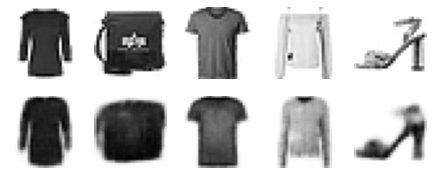

In [260]:
show_reconstructions(VAE)
plt.show()

/home/dongho/anaconda3/envs/HOML/lib/python3.10/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/home/dongho/anaconda3/envs/HOML/lib/python3.10/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


그림 저장 VAE_2D


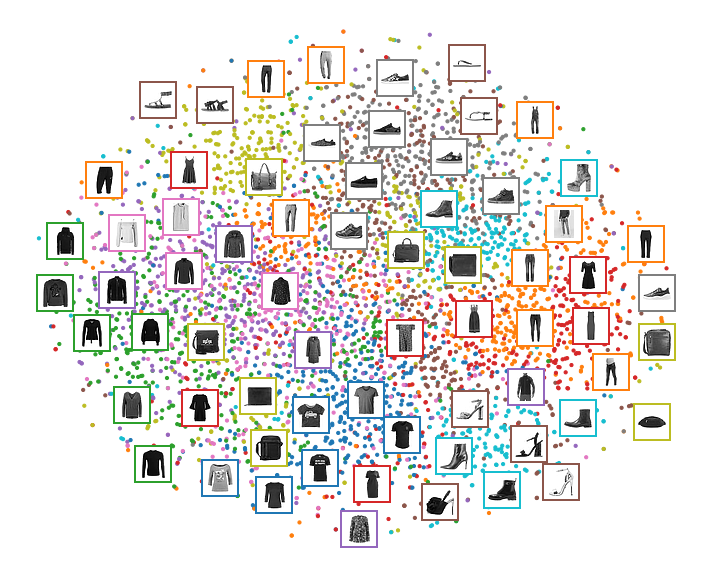

In [269]:
plot_representation_in_2D(VAE_encoder ,"VAE_2D", X_valid)

#### Making Fashion Mnist image

In [270]:
codings_test = tf.random.normal(shape=[12, codings_size])
images = variational_decoder(codings_test).numpy()

In [271]:
def plot_multiple_images(images, n_cols=None):
    n_cols = n_cols or len(images)
    n_rows = (len(images) - 1) // n_cols + 1
    if images.shape[-1] == 1:
        images = np.squeeze(images, axis=-1)
    plt.figure(figsize=(n_cols, n_rows))
    for index, image in enumerate(images):
        plt.subplot(n_rows, n_cols, index + 1)
        plt.imshow(image, cmap="binary")
        plt.axis("off")

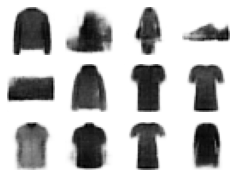

In [272]:
plot_multiple_images(images, 4)

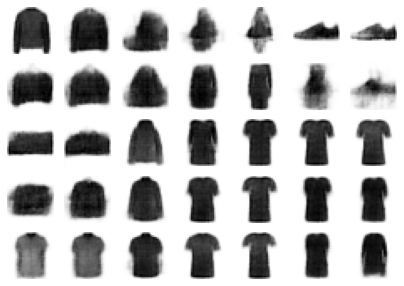

In [273]:
codings_grid = tf.reshape(codings_test, [1, 3, 4, codings_size])
larger_grid = tf.image.resize(codings_grid,size=[5, 7]) # resize는 선형보간 이용하기 때문!
interpolated_codings = tf.reshape(larger_grid, [-1, codings_size])
images = variational_decoder(interpolated_codings)
plot_multiple_images(images, 7)